In [ ]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.data import Dataset
from tensorflow.keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [ ]:
!wget --no-check-certificate \
  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
  -O sunspots.csv

--2023-05-06 06:39:11--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘sunspots.csv’

sunspots.csv        100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2023-05-06 06:39:11 (5.08 MB/s) - ‘sunspots.csv’ saved [67921/67921]



In [ ]:
time = []
temps = []

with open("sunspots.csv", "r") as file:
  reader = csv.reader(file)
  next(reader)
  for row in reader:
    time.append(row[0])
    temps.append(float(row[1]))

In [ ]:
time = np.array(time)
temps = np.array(temps)

split_size = int(0.8 * len(time))

train_time = time[:split_size]
x_train = temps[:split_size]

valid_time = time[split_size:]
x_valid = temps[split_size:]


In [ ]:
def windowed_dataset(series, window_size, batch_size, buffer_size):
  dataset = Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(buffer_size).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

window_size = 20
batch_size = 30
buffer_size = 1000

train_dataset = windowed_dataset(x_train, window_size, batch_size, buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, buffer_size)

In [ ]:
naive_forecast = temps[split_size-1:-1]
metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

1.9527397260273973

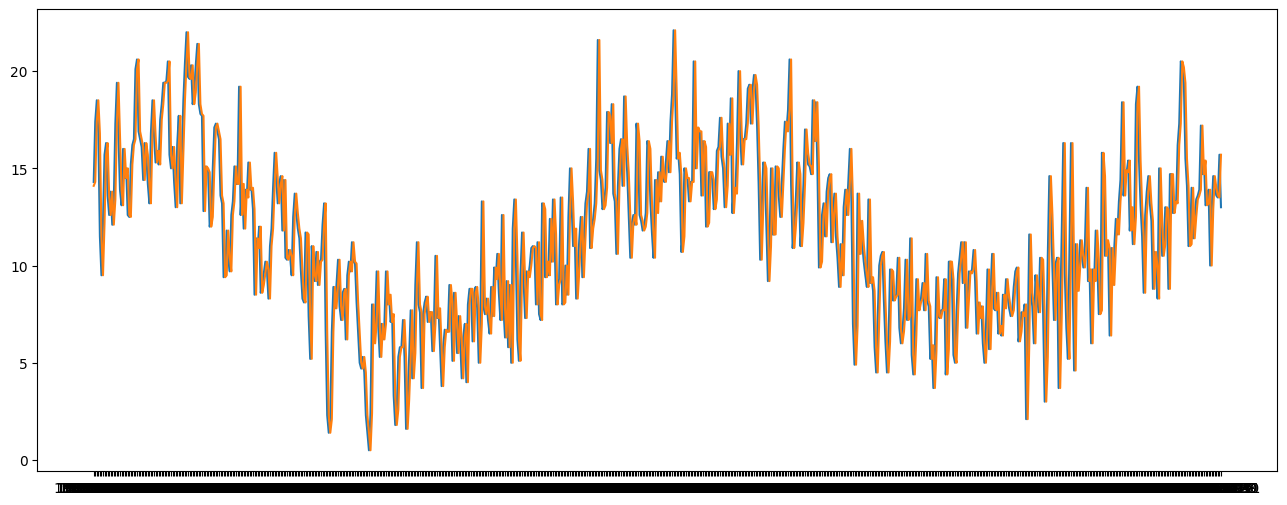

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time[split_size:], temps[split_size:])
plt.plot(time[split_size:], naive_forecast)

In [ ]:
model = Sequential()

model.add(layers.Conv1D(100, kernel_size=5, input_shape=(None, 1), activation="relu"))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.LSTM(100, return_sequences=True))
model.add(layers.Dense(30, activation="relu"))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1))
model.add(layers.Lambda(lambda x: x * 100.0))

lr_scheduler = LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch / 20)))
save_best = ModelCheckpoint("best_weights.hdf5", save_best_only=True)

model.compile(optimizer=SGD(learning_rate=1e-6, momentum=0.9), loss="mse")

In [ ]:
hist = model.fit(train_dataset, epochs=200, validation_data=valid_dataset, callbacks=[])

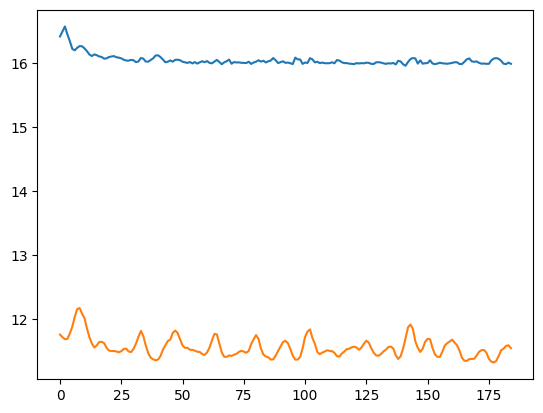

In [ ]:
plt.plot(hist.history["loss"][15:])
plt.plot(hist.history["val_loss"][15:])

In [ ]:
forecast = []

for t in range(len(time)-window_size):
  pred = model.predict(np.expand_dims(temps[t:t + window_size], axis=0), verbose=0).squeeze()
  forecast.append(pred)

forecast = np.array(forecast)

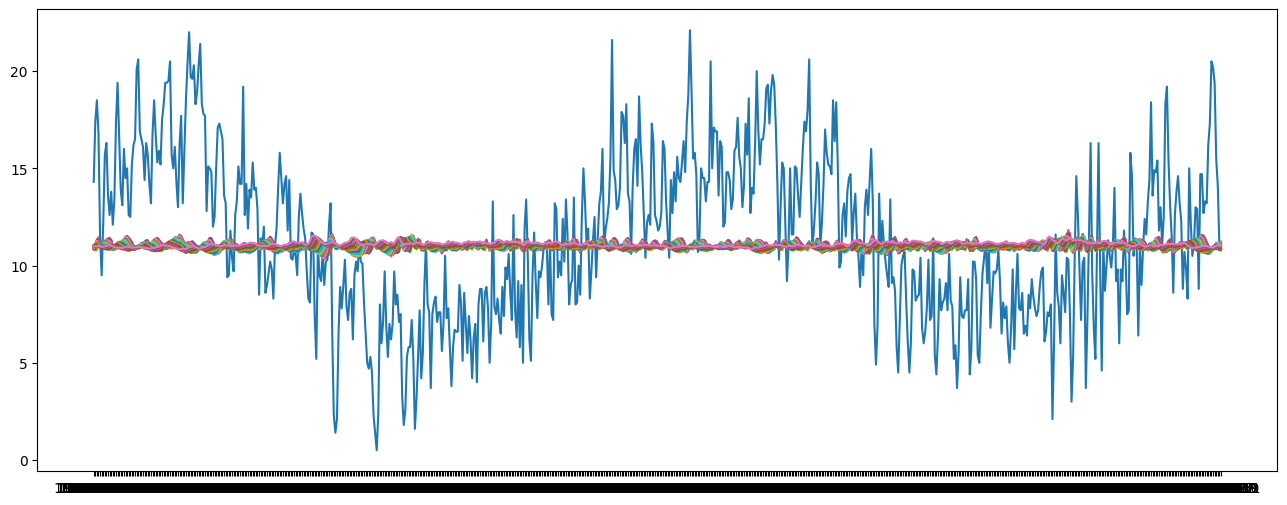

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(time[split_size:-window_size], temps[split_size:-window_size])
plt.plot(time[split_size:-window_size], forecast[split_size:])

In [ ]:
metrics.mean_absolute_error(x_valid[:-window_size], forecast[split_size:]).numpy()

In [ ]:
plt.semilogx(hist.history["lr"], hist.history["loss"])

In [ ]:
model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, None, 100)         600       
                                                                 
 lstm_40 (LSTM)              (None, None, 100)         80400     
                                                                 
 lstm_41 (LSTM)              (None, None, 100)         80400     
                                                                 
 dense_89 (Dense)            (None, None, 30)          3030      
                                                                 
 dense_90 (Dense)            (None, None, 10)          310       
                                                                 
 dense_91 (Dense)            (None, None, 1)           11        
                                                                 
 lambda_18 (Lambda)          (None, None, 1)         